In [ ]:
#Setup Area, mainly for import, functions and data reading
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from category_encoders import MEstimateEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def score_dataset(X, y, model=XGBRegressor(n_estimators=220,learning_rate=0.06,random_state=0,max_depth=7)):
    score = cross_val_score(model, X, y, cv=5, scoring="neg_mean_squared_log_error",)
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

def score_model(X, y, model):
    score = cross_val_score(model, X, y, cv=5, scoring="neg_mean_squared_log_error",)
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

# Read the data
X_full = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv", index_col='Id')
X_test_full = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv", index_col='Id')
df=X_full.copy()
# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)



# INTRO

This solution based on a XGBRegressor model as scoring method for data preparation.
So far was done following steps:
- Filling NaN with NA and 0 respectively on Cathegorical and numeric data
- All cathegorical data was encoded with OrdinalEncoder and GetDummies
- All feature columns was saved from droping, droping of any of them show from 0 to negative impact on a model and final score
- The right skewed normal distribution of SalePrice was normalized with np.log1p, which showed a positive impact
- 1 New feature was created based on numerical data which logicaly make sense and showed some positive impact on the model and scoring, there is a potential for improving in this field, may be some PCA(to be done)
- Also normalizing data should be considered as potential step for improve(to be done)
- Unfortunately cutting off the Outliers show from 0 to negative impact on final Scoring, and directly are not considering as an option
- After minor modification on the data some more regression models were considered to use in this task. So far the parameters tuning are still an unfinished job, but the ensemble composition of three models has shown pretty good improvent on the score result.
-Normal Pipeline is currently abscent(to be done)

In [ ]:
# Show no impact, but possible area
#Drop column list of mostly NAN features
#drop_cols=["PoolQC","MiscFeature","Alley","Fence","FireplaceQu"]
#print(df.isnull().sum().sort_values(ascending = False).head(10))
#X_full.drop(columns=drop_cols, inplace=True)
#X_test_full.drop( columns=drop_cols, inplace=True)


# Data Encoding

In [ ]:

# Select categorical columns with relatively low cardinality (convenient but arbitrary)

categorical_cols = [cname for cname in X_full.columns if 
                    X_full[cname].dtype == "object" and 
X_full[cname].nunique() <10]

ordinal_cols= [cname for cname in X_full.columns if 
                    X_full[cname].dtype == "object" and 
X_full[cname].nunique() >9 ]
# Select numerical columns
numerical_cols = [cname for cname in X_full.columns if 
                X_full[cname].dtype in ['int64', 'float64']]

# FillNA part
X_full[numerical_cols]=X_full[numerical_cols].fillna(0, axis=1)
X_test_full[numerical_cols]=X_test_full[numerical_cols].fillna(0, axis=1)
# Ordinal Encoding
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)
X_full[ordinal_cols] = ordinal_encoder.fit_transform(X_full[ordinal_cols])
X_test_full[ordinal_cols] = ordinal_encoder.transform(X_test_full[ordinal_cols])

X=X_full.copy()
X_test=X_test_full.copy()
# One-hot encoding with Dummies from Pandas
X=pd.get_dummies(X,dummy_na=True)
X_test = pd.get_dummies(X_test,dummy_na=True)
X, X_test = X.align(X_test, join='left', axis=1)
X_1=X.copy()
X_1_test=X_test.copy()

print(score_dataset(X,y))

Raw encoded data shows score 0.13304 in internal scoring which corresponds to 0.13475 in competition validation. Next steps:
- observe the features with maximal impact and search for outliers((Done!negative impact on deleting the outliers))
- try to create a usefull feature based on the parameter relations to another features(1 Feature Done!more to go!)
- drop the Zero-potential features from dataset(Done!negative impact)
- Normalize important numeric features(to be done)

In [ ]:
sns.displot(df['SalePrice'])
plt.show()

In [ ]:
log_SalePrice = np.log1p(df['SalePrice'])
sns.displot(log_SalePrice)

In [ ]:
#X_1_test.NewF_1.describe()

In [ ]:
discrete_features = X_1[numerical_cols].dtypes == int
mi_scores =make_mi_scores(X_1[numerical_cols], y, discrete_features)
#mi_scores=[round(x,5) for x in mi_scores]
print(round(mi_scores[:10],5))

We will now take a look closer on the features with highest impact and will seek for outliers. 

In [ ]:
df_1=df.copy()
plt.figure(figsize = (5,5))
sns.scatterplot(data = df_1, x = 'GrLivArea',y = 'SalePrice')
sns.regplot(data = df_1, x = 'GrLivArea',y = 'SalePrice', line_kws = {'color':'red'})

plt.figure(figsize = (5,5))
sns.scatterplot(data = df_1, x = 'GarageArea',y = 'SalePrice')
sns.regplot(data = df_1, x = 'GarageArea',y = 'SalePrice', line_kws = {'color':'red'})


plt.figure(figsize = (5,5))
sns.scatterplot(data = df_1, x = 'TotalBsmtSF',y = 'SalePrice')
sns.regplot(data = df_1, x = 'TotalBsmtSF',y = 'SalePrice', line_kws = {'color':'red'})


plt.figure(figsize = (5,5))
sns.scatterplot(data = df_1, x = 'YearBuilt',y = 'SalePrice')
sns.regplot(data = df_1, x = 'YearBuilt',y = 'SalePrice', line_kws = {'color':'red'})

plt.figure(figsize = (5,5))
sns.scatterplot(data = df_1, x = 'LotArea',y = 'SalePrice')
sns.regplot(data = df_1, x = 'LotArea',y = 'SalePrice', line_kws = {'color':'red'})

df_1["NewF_1"]=df_1.GrLivArea/df_1.TotRmsAbvGrd


#print(round(make_mi_scores(X_1[discrete_features], y_1, discrete_features)[:10],5))
plt.figure(figsize = (10,10))
sns.scatterplot(data = df_1, x = "NewF_1",y = 'SalePrice')
sns.regplot(data = df_1, x = "NewF_1",y = 'SalePrice', line_kws = {'color':'red'})

"PoolArea" is a candidate for a "drop" there is no correlation in this feature because the distribution of the data is 0-based with some outliers.
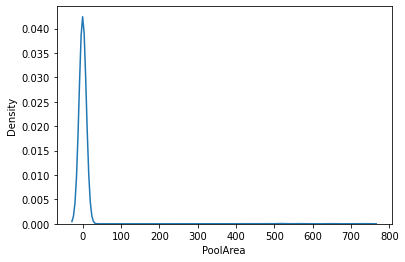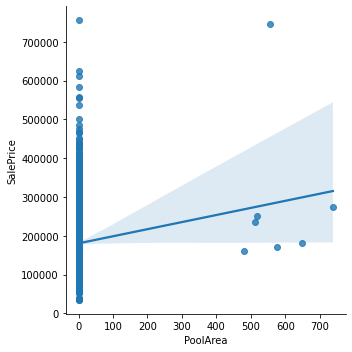






"MiscVal" has the same problem, lots of 0 data. logicaly it should make impact,but...
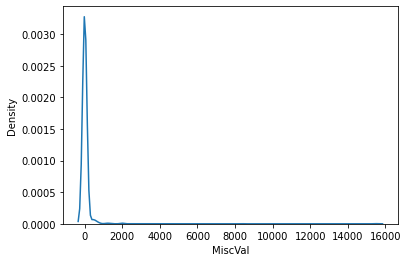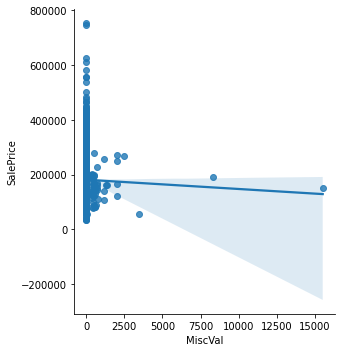

**3SsnPorch** - Has same problem in this data set, too much 0 values, but it shows some minor correlation with SalePrice. Hypothese: there are 4 types of porches presented in the area, which are separeted with type of weather protection but all corresponde to one main utility "the porch area", I will try to combine 3 covered porches into new feature **"ClPorch"=3SsnPorch+ScreenPorch+EnclosedPorch**
(Done!negative impact)
**MoSold** & **YrSold** - Has no impact SalePrice, but should, in fact it is part of the "how old is the house" question. I am pretty sure that the year of built is answering this question, from this two features we can produce only the time in years from last major construction works(construction or renovation) safe decision is just drop them out, but we will try to create feature **YrOldRem=YrSold-YrRemodAdd**.((Done!negative impact))

In [ ]:
#place to create new features and drop columns(drop list is above),
#here we can check if new feature or column made any impact or not
y_1=y.copy()
y_1=np.log1p(y_1)

X_1["SalePrice"]=y_1

X_1["NewF_1"]=X_1.GrLivArea/(1+X_1.TotRmsAbvGrd)
#X_1=X_1[X_1.GarageArea<1200]
#X_1=X_1[df.GrLivArea<3000]
#X_1=X_1[df.TotalBsmtSF<2300]
#X_1=X_1[df.LotArea<20000]
y_1=X_1.SalePrice
X_1.drop(['SalePrice'], axis=1, inplace=True)
#X_1["YrOldRem"]=X_1.YrSold-X_1.YearRemodAdd
#X_1.drop(columns=drop_cols,inplace=True)


X_1_test["NewF_1"]=X_1_test.GrLivArea/(1+X_1_test.TotRmsAbvGrd)
#X_1_test["ClPorch"]=X_1_test["3SsnPorch"]+X_1_test.ScreenPorch+X_1_test.EnclosedPorch
#X_1_test["YrOldRem"]=X_1_test.YrSold-X_1_test.YearRemodAdd
#X_1_test.drop(columns=drop_cols,inplace=True)
print("Score after mod.:",score_dataset(X_1,y_1))


In [ ]:
X_1_test.describe()
X_1=X_1.fillna(value=0)

# Some chip tuning...
there is nothing interesting here

In [ ]:
 """
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV


# define grid
params = { 'max_depth': [5,6,7,8],
           'learning_rate': [0.01,0.03, 0.06, 0.1],
           'n_estimators': [110,220,330,440],
           'colsample_bytree': [0.3, 0.7]}
xgbr = XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X_1, y_1)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))
 """

In [ ]:
 """
from sklearn.model_selection import StratifiedShuffleSplit,RepeatedStratifiedKFold
shuffle_split = StratifiedShuffleSplit(test_size=0.25,train_size=0.75,n_splits=35,random_state=87951)
#kfold = RepeatedStratifiedKFold(n_splits=25, n_repeats=10, random_state=87951)
param_grid = {
                'alpha'     : [0.1,1,10,0.01],
                'l1_ratio'  :  np.arange(0.40,1.00,0.10),
                'tol'       : [0.0001,0.001]
            }
eNet = ElasticNet(max_iter=10000)
grid_search = GridSearchCV(eNet, 
                           param_grid, 
                           scoring='roc_auc', 
                           cv = shuffle_split,
                           return_train_score=True,
                           n_jobs = -1)
grid_search.fit(X_1, y_1)
print("Best parameters:", grid_search.best_params_)
     
############################
# Create the parameter grid based on the results of random search 
#param_grid = {
#    'bootstrap': [True],
#    'max_depth': [80, 90, 100, 110],
#    'max_features': [2, 3],
#    'min_samples_leaf': [3, 4, 5],
#    'min_samples_split': [8, 10, 12],
#    'n_estimators': [100, 200, 300, 1000]
#}
# Create a based model
#rf = RandomForestRegressor()
# Instantiate the grid search model
#grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                          cv = 3, n_jobs = -1, verbose = 2)
#grid_search.fit(X_1,y_1)
#grid_search.best_params_#"""

# Modeling

Four models are considered and best of 3 will be Ensembled and mean value from three models will be submited

In [ ]:
# Define the model
model = XGBRegressor(n_estimators=220,learning_rate=0.06,random_state=0,max_depth=7) # Some tuning here
model_2=  ElasticNet(alpha = 0.0005, l1_ratio = .5, random_state = 0)
model_3=  RandomForestRegressor(bootstrap=True,max_depth= 80,max_features= 3,min_samples_leaf= 3,
 min_samples_split=8,n_estimators= 300, random_state = 0)
model_4=  Lasso(alpha = 0.0005,random_state = 0)
# Fit the model
model.fit(X_1,y_1)
model_2.fit(X_1,y_1)
model_3.fit(X_1,y_1)
model_4.fit(X_1,y_1)
# Score models
models=[model,model_2,model_3,model_4]
for i in models:
    print(score_model(X_1,y_1,i))
X_1_test=X_1_test.fillna(value=0)


# Submission
**Ensamble**
The predicted values are converted back from log with help of np.expm1

In [ ]:
# Submission file
preds_test = model.predict(X_1_test)
preds_2_test = model_2.predict(X_1_test)
preds_4_test= model_4.predict(X_1_test)
preds_mean= (preds_test+preds_2_test+preds_4_test)/3
output = pd.DataFrame({'Id': X_1_test.index,
                       'SalePrice':  np.expm1(preds_mean)})

output.to_csv('submission.csv', index=False)
output.head()

So far no improvement on competion score, looks like droping and new features show little to no impact on model...